# Project: Deep Research with LangGraph - Module 2: Research Agent

# Research Agent

In [1]:
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

In the scoping phase, the agent clarified the user's intent and returned a research brief. Now the research agent will gather the context requested by the research brief.

Research is an open-ended task. The best strategy to answer a user request cannot be easily known in advance.

Requests can require different research strategies and varying levels of search depth. Listing and ranking requests typically require open-ended search, followed by a synthesis and ranking.

The research agent will follow a simple yet effective pattern:
1. **LLM Decision Node** - Analyzes the current state and decides whether to make tool calls or provide a final response.
2. **Tool Execution Node** - Executes search tools when the LLM determines more information is needed.
3. **Research Compression Node** - Summarizes and compresses research findings for efficient processing.
4. **Routing Logic** - Determines workflow continuation based on LLM decisions.

# Prompt

We will first define a prompt that instructs our agent to use available search tools.

To prevent excessive tool calls and maintain research focus, we will use [a few prompting techniques](https://www.youtube.com/watch?v=XSZP9GhhuAc):
1. **Think Like the Agent**: What instructions would we give to a new work colleague?
    - Read the question carefully - What specific information does the user need?
    - Start with broader searches - Use broad, comprehensive queries first
    - After each search, pause and assess - Do I have enough to answer? What is still missing?
    - Execute narrower searches as we gather information - Fill in the gaps.

2. **Concrete Heuristics** (Prevent "Spin-Out" on excessive tool calls): Use **hard limits** to prevent the research agent from calling tools excessively.
    - Stop when we can answer confidently - Don't keep searching for perfection.
    - Give it budgets - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
    - Limit - Always stop after 5 search tool calls if we cannot find the right source(s).

3. **Show the Thinking**: After each search tool calling, use [`think_tool`](https://www.anthropic.com/engineering/claude-think-tool) to analyze the results:
    - What key information did I find?
    - What is missing?
    - Do I have enough to answer the question comprehensively?
    - Should I search more or provide my answer now?

In [2]:
from utils import show_prompt
from deep_research_from_scratch.prompts import research_agent_prompt

show_prompt(research_agent_prompt, "Research Agent Prompt")

┌─────────────────────────── Research Agent Prompt ───────────────────────────┐
│                                                                             │
│  You are a research assistant conducting research on the user's input       │
│  topic. For context, today's date is {date}.                                │
│                                                                             │
│  <Task>                                                                     │
│  Your job is to use tools to gather information about the user's input      │
│  topic.                                                                     │
│  You can use any of the tools provided to you to find resources that can    │
│  help answer the research question. You can call these tools in series or   │
│  in parallel, your research is conducted in a tool-calling loop.            │
│  </Task>                                                                    │
│                                       

# State and Schemas

In [5]:
%%writefile ./src/deep_research_from_scratch/state_research.py
"""State definitions and Pydantic schemas for Research Agent.

Description: This module defines the state objects and structured schemas use for the research agent workflow,
including researcher state management and output schemas.
"""
import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# ===== STATE DEFINITIONS =====

class ResearcherState(TypedDict):
    """State for the research agent containing message history and research metadata.
    This state tracks the researcher's conversation, iteration count for limiting tool calls,
    the research topic being investigated, compressed findings, and raw research notes for details analysis.
    """
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]


class ResearcherOutputState(TypedDict):
    """Output state for the research agent containing the final research results.
    This represents the final output of the research process with compressed research findings
    and all raw notes from the research process.
    """
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]


# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decisions during scoping phase."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question."
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope"
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information."
    )


class ResearchQuestion(BaseModel):
    """Schema for research brief generation."""
    research_brief: str = Field(
        description="A research question that will be used to guide the research."
    )


class Summary(BaseModel):
    """Schema for webpage content summarization."""
    summary: str = Field(
        description="Concise summary of the webpage content"
    )
    key_excerpts: str = Field(
        description="Important quotes and excerpts from the content"
    )

Overwriting ./src/deep_research_from_scratch/state_research.py


# Tavily SDK Integration

To define our research tool, we will use the Tavily SDK to perform web searches. Tavily is a search engine optimized for AI applications, providing
- real-time web search results
- content extraction and summarization
- domain filtering and result ranking
- async support for performance


Alternative web content sources:
- **Tavily Extract** - Tavily's dedicated content extraction endpoint that can extract and clean content from specific URLs without performing searches.
- **Jina Reader** - A powerful web content extraction service that convert web pages to clean, LLM-friendly text by simply prepending https://r.jina.ai/ to any URL
- **Firecrawl** - A comprehensive web scraping platform that converts websites into clean markdown or structured data, with advanced features like JavaScript rendering and sitemap crawling

# LangChain Tools

We will convert our Tavily search function into a LangChain tool using the `@tool` decorator.

In [16]:
%%writefile ./src/deep_research_from_scratch/utils.py
"""Research Utilities and Tools.

Description: This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""
from pathlib import Path
from datetime import datetime
from typing_extensions import Annotated, List, Literal

from langchain.chat_models import init_chat_model 
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from tavily import TavilyClient

from deep_research_from_scratch.state_research import Summary
from deep_research_from_scratch.prompts import summarize_webpage_prompt

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    # Use cross-platform format or handle Windows specifically
    today = datetime.now()
    return today.strftime("%a %b %d, %Y").replace(" 0", " ")


def get_current_dir() -> Path:
    """Get the current directory of this module.
    This function is compatible with both Jupyter notebooks and standard Python scripts.
    
    Returns:
        (Path): The current directory as a Path object.
    """
    try:
        return Path(__file__).resolve().parent
    except NameError: # __file__ is not defined in Jupyter notebooks
        return Path.cwd()


# ===== CONFIGURATION =====

summarization_model = init_chat_model(model='openai:gpt-4.1-mini')
tavily_client = TavilyClient()

# ===== SEARCH FUNCTIONS =====

def tavily_search_multiple(
    search_queries: List[str],
    max_results: int = 3,
    topic: Literal['general', 'news', 'finance'] = 'general',
    include_raw_content: bool = True
) -> List[dict]:
    """Perform search using Tavily API for multiple queries.
    
    Args:
        search_queries (List[str]): List of search queries to execute.
        max_results (int): Maximum number of results per query.
        topic (Literal['general', 'news', 'finance']): Topic filter for search results.
        include_raw_content (bool): Whether to include raw webpage content.
        
    Returns:
        List[dict]: List of search result dictionaries.
    """
    # Execute searches sequentially. For parallel execution, we can use `AsyncTavilyClient` to parallelize this step.
    search_docs = []
    for query in search_queries:
        result = tavily_client.search(
            query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic
        )
        search_docs.append(result)

    return search_docs


def summarize_webpage_content(webpage_content: str) -> str:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content (str): Raw content of the webpage to summarize.
        
    Returns:
        str: Formatted summary with key excerpts.
    """
    try:
        # Set up structured output model for smmarization
        structured_model = summarization_model.with_structured_output(Summary)
        # Generate summary
        summary = structured_model.invoke([
            HumanMessage(content=summarize_webpage_prompt.format(
                webpage_content=webpage_content,
                date=get_today_str()
            ))
        ])

        # Format summary with clear structure
        formatted_summary = (
            f"<summary>\n{summary.summary}\n</summary>\n\n"
            f"<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"
        )

        return formatted_summary
    except Exception as e:
        print(f"Failed to summarize webpage: {str(e)}")
        return webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content


def deduplicate_search_results(search_results: List[dict]) -> dict:
    """Deduplicate search results by URL to avoid processing duplicate content.
    
    Args:
        search_results (List[dict]): List of search result dictionaries.
        
    Returns:
        dict: Dictionary mapping URLs to unique results
    """
    unique_results = {}
    
    for response in search_results:
        for result in response['results']:
            url = result['url']
            if url not in unique_results:
                unique_results[url] = result

    return unique_results


def process_search_results(unique_results: dict) -> dict:
    """Process search results by summarizing content where available.
    
    Args:
        search_results (dict): Dictionary of unique search results.
        
    Returns:
        dict: Dictionary of processed search results with summaries.
    """
    summarized_results = {}

    for url, result in unique_results.items():
        # Use existing content if no raw content for summarization
        if not result.get('raw_content'):
            content = result['content']
        else:
            # Summarize raw content for better processing
            content = summarize_webpage_content(result['raw_content'])

        summarized_results[url] = {
            'title': result['title'],
            'content': content,
        }

    return summarized_results


def format_search_output(summarized_results: dict) -> str:
    """Format search results into a well-structured string output.
    
    Args:
        summarized_results (dict): Dictionary of processed search results.
        
    Returns:
        str: Formatted string of search results with clear source separation.
    """
    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."

    formatted_output = "Search results: \n\n"

    for i, (url, result) in enumerate(summarized_results.items(), start=1):
        formatted_output += f"\n\n--- SOURCE {i}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result['content']}\n\n"
        formatted_output += "-" * 80 + "\n"

    return formatted_output


# ===== RESEARCH TOOLS =====

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal['general', 'news', 'finance'], InjectedToolArg] = 'general'
) -> str:
    """Fetch results from Tavily search API with content summarization.
    
    Args:
        query (str): A single search query to execute.
        max_results (int): Maximum number of results to return.
        topic (Literal['general', 'news', 'finance']): Topic filter for search results.
        
    Returns:
        str: Formatted string of search results with summaries.
    """
    # Execute search for single query
    search_results = tavily_search_multiple(
        [query], # Convert single query to list for the internal function
        max_results=max_results,
        topic=topic,
        include_raw_content=True
    )

    # Deduplicate results by URL to avoid processing duplicate content
    unique_results = deduplicate_search_results(search_results)

    # Process results by summarizing content where available
    summarized_results = process_search_results(unique_results)

    # Format results into a well-structured string output
    formatted_output = format_search_output(summarized_results)

    return formatted_output



@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for stragetic reflection on research progress and decision-making.
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Args:
        reflection (str): Your detailed reflection on research progress, findings, gaps, and next steps.
        
    Returns:
        str: Confirmation that reflection was recorded for decision-making.
    """
    return f"Reflection recorded: {reflection}"

Overwriting ./src/deep_research_from_scratch/utils.py


**`InjectedToolArg`**:
- Note that some of the arguments in `tavily_search` are noted as `InjectedToolArg`. These are **NOT** included in the tool schema sent to the LLM, and instead are injected during tool execution runtime.
- This gives use the flexibility to inject values at runtime, but does not burden the language model with the responsibility of managing these arguments.


**`parse_docstring=True`**:
- This option tells LangChain to parse the function's docstring to automatically generate the tool's description and argument schema.


For example, in the `tavily_search` function, we add the `@tool` decorator with `parse_docstring=True` to create a LangChain tool, then LangChain will parse the function's docstring to generate the tool's schema:

```python
    """Fetch results from Tavily search API with content summarization.
        
    Args:
        query (str): A single search query to execute.
        max_results (int): Maximum number of results to return.
        topic (Literal['general', 'news', 'finance']): Topic filter for search results.
        
    Returns:
        str: Formatted string of search results with summaries.
    """
```

However, since `max_results` and `topic` are marked as `InjectedToolArg`, they will not be included in the tool schema sent to the LLM.

Beyond this, this is just a regular Python function, so we can call it directly in our code as well.

# Research Agent

The **research agent** will perform iterative tool-calling to search the information.

Recall that the research agent follows a simple yet effective pattern:
1. **LLM Decision Node** - Analyzes the current state and decides whether to make tool calls or provide a final response.
2. **Tool Execution Node** - Executes search tools when the LLM determines more information is needed.
3. **Research Compression Node** - Summarizes and compresses research findings for efficient processing.
4. **Routing Logic** - Determines workflow continuation based on LLM decisions.

We will apply [**context engineering**](https://blog.langchain.com/context-engineering-for-agents/) in two places to help the agent manage its context effectively:



1. **Webpage Content Summarization** - Raw search results often contain excessive noise (navigation, ads, boilerplate content). The `summarize_webpage_content()` function will
    - Use structured output to extract key information and relevant excerpts
    - Filter out irrelevant content while preserving factual details
    - Compress lengthy articles into focused summaries
    - Maintain source attribution for credibility

2. **Research Result Compression** - As the agent performs multiple searches, the conversation context grows rapidly. The `compress_research()` function will
    - Synthesize findings from multiple tool calls into cohesive insights
    - Extract raw notes for detailed analysis while maintaining compressed summaries
    - Reduce token usage for subsequent LLM calls
    - Preserve essential information for report writing

3. **Performing Careful Compression** - We need to be very careful about losing valuable information during compression. We will use an LLM for compression with instructions in a system prompt that comes before a potentially long, token-heavy trajectory of multiple tool calls. The long context can cause the compression LLM to lose sight of the task instructions, leading to generic summaries that lose important details. To mitigate this, we will have the `compress_research_human_message` function that will
    - Explicitly restate the original research topic at compression time
    - Remind the model to preserve ALL information relevant to the specific question
    - Emphasize that comprehensive findings are critical for final report generation
    - Prevent task drift during the compression phase

4. **Output Token Management** - Research compression can generate long outputs. We need to ensure that they do not exceed model token limits, which can cause truncated responses that cut off mid-sentence.

In [17]:
%%writefile ./src/deep_research_from_scratch/research_agent.py
"""Research Agent Implementation.

Description: This module implements the research agent that can perform iterative web searches and synthesis to answer complex research questions.
"""
from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain.chat_models import init_chat_model

from deep_research_from_scratch.state_research import ResearcherState, ResearcherOutputState
from deep_research_from_scratch.utils import tavily_search, get_today_str, think_tool
from deep_research_from_scratch.prompts import research_agent_prompt, compress_research_system_prompt, compress_research_human_message


# ===== CONFIGURATION =====

# Set up tools and model binding
tools = [tavily_search, think_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize models
model = init_chat_model(model='anthropic:claude-sonnet-4-20250514')
model_with_tools = model.bind_tools(tools)
summarization_model = init_chat_model(model='openai:gpt-4.1-mini')
compress_model = init_chat_model(model='openai:gpt-4.1', max_tokens=32000)

# ===== AGENT NODES =====

def llm_call(state: ResearcherState):
    """Analyze current state and decide on next actions.
    The model analyzes the current conversation state and decides whether to
    1. call search tools to gather more information,
    2. provide a final answer based on gathered information.
    
    Args:
        state (ResearcherState): Current state of the research agent.
        
    Returns:
        ResearcherState: Updated state after model decision.
    """
    return {
        'researcher_messages': [
            model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt)] + state['researcher_messages']
            )
        ]
    }


def tool_node(state: ResearcherState):
    """Execute all tool calls from the previous LLM response.
    
    Args:
        state (ResearcherState): Current state of the research agent.
    
    Returns:
        ResearcherState: Updated state with tool responses added to message history.
    """
    tool_calls = state['researcher_messages'][-1].tool_calls

    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call['name']]
        observations.append(tool.invoke(tool_call['args']))

    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call['name'],
            tool_call_id=tool_call['id']
        ) for observation, tool_call in zip(observations, tool_calls)
    ]

    return {
        'researcher_messages': tool_outputs
    }


def compress_research(state: ResearcherState) -> dict:
    """Compress research findings into a concise summary.
    Take all the research messages and tool outputs and create a compressed summary
    suitable for the supervisor's decision-making.
    """
    system_message = compress_research_system_prompt.format(date=get_today_str())

    messages = [SystemMessage(content=system_message)] + state.get('researcher_messages', []) + [HumanMessage(content=compress_research_human_message)]
    response = compress_model.invoke(messages)

    # Extract raw notes from tool and AI messages
    raw_notes = [
        str(m.content) for m in filter_messages(
            state['researcher_messages'],
            include_types=['tool', 'ai']
        )
    ]

    return {
        'compressed_research': str(response.content),
        'raw_notes': ['\n'.join(raw_notes)]
    }


# ===== ROUTING LOGIC =====

def should_continue(state: ResearcherState) -> Literal['tool_node', 'compress_research']:
    """Determine whether to continue research or provide final answer.
    
    Args:
        state (ResearcherState): Current state of the research agent.
        
    Returns:
        Literal['tool_node', 'compress_research']: Next node to route to.
    """
    messages = state['researcher_messages']
    last_message = messages[-1]

    # If the LLM makes a tool call, continue to tool execution
    if last_message.tool_calls:
        return 'tool_node'
    # Otherwise, finalize research
    return 'compress_research'


# ===== GRAPH CONSTRUCTION =====

# Build the agent workflow
agent_builder = StateGraph(
    ResearcherState,
    output_schema=ResearcherOutputState
)

# Add nodes
agent_builder.add_node('llm_call', llm_call)
agent_builder.add_node('tool_node', tool_node)
agent_builder.add_node('compress_research', compress_research)

# Add edges
agent_builder.add_edge(START, 'llm_call')
agent_builder.add_conditional_edges(
    'llm_call',
    should_continue,
    {
        'tool_node': 'tool_node', # Continue research loop
        'compress_research': 'compress_research' # Finalize research
    }
)
agent_builder.add_edge('tool_node', 'llm_call') # loop back for more research
agent_builder.add_edge('compress_research', END) # end after compression

# Compile
researcher_agent = agent_builder.compile()

Overwriting ./src/deep_research_from_scratch/research_agent.py


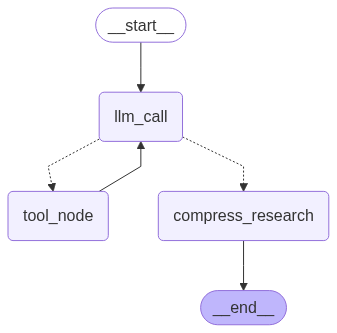

In [18]:
from IPython.display import display, Image
from deep_research_from_scratch.research_agent import researcher_agent

display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

In [19]:
# Run the agent
from utils import format_messages
from langchain_core.messages import HumanMessage

# Example brief
research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = researcher_agent.invoke({"researcher_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['researcher_messages'])

┌─────────────────────────────────── Human ───────────────────────────────────┐
│ I want to identify and evaluate the coffee shops in San Francisco that are  │
│ considered the best based specifically                                      │
│ on coffee quality. My research should focus on analyzing and comparing      │
│ coffee shops within the San Francisco area,                                 │
│ using coffee quality as the primary criterion. I am open regarding methods  │
│ of assessing coffee quality (e.g.,                                          │
│ expert reviews, customer ratings, specialty coffee certifications), and     │
│ there are no constraints on ambiance,                                       │
│ location, wifi, or food options unless they directly impact perceived       │
│ coffee quality. Please prioritize primary                                   │
│ sources such as the official websites of coffee shops, reputable            │
│ third-party coffee review organization

In [20]:
from rich.markdown import Markdown
Markdown(result['compressed_research'])

List of Queries and Tool Calls Made                                                                                

 1 Query: best coffee shops San Francisco 2024 2025 coffee quality specialty coffee expert reviews                 
   Source: Yelp, Sugar & Stamps, Eater SF                                                                          
 2 Query: "Coffee Review" "Specialty Coffee Association" San Francisco coffee shops ratings quality 2024 2025      
   Source: Coffee Bros., Mountain Lyon Cafe, Lemon8-app                                                            
 3 Query: Blue Bottle Four Barrel Ritual Andytown Flywheel coffee quality reviews San Francisco espresso specialty 
   2024                                                                                                            
   Source: Sugar & Stamps, Yelp.ca, Yelp                                                                           
 4 Query: "Saint Frank Coffee" "Sextant Coffee" "Telescope Coffee" San Francisco coffee quality reviews ratings    
   2024 2025                                                                                                       
   Source: Eater SF, Wanderlog                                                                                     
 5 Query: Google reviews Yelp San Francisco coffee shops coffee quality espresso ratings "Four Barrel" "Blue       
   Bottle" "Ritual" customer feedback                                                                              
   Source: Yelp (multiple searches)                                                                                

Fully Comprehensive Findings                                                                                       

 1 Paper Son Coffee. 4.5 (57 reviews). 2.8 mi. 303 2nd St N102, San Francisco, CA 94107                            
 2 Andytown Coffee Roasters. 4.5 (1.1k reviews). 3.6 mi. 3655 Lawton St                                            
   (Yelp) [1]                                                                                                      

The Sugar & Stamps webpage, published on September 29, 2017, offers a curated guide to the best coffee shops in San
Francisco. The author, a self-proclaimed coffee connoisseur, highlights a variety of specialty coffee spots across 
the city, emphasizing unique offerings and atmospheres. Notable mentions include Andytown Coffee Roasters known for
the Snowy Plover coffee float; Blue Bottle Coffee, famed for single origin beans with a recommendation to visit the
Ferry Building location; Cafe Réveille with its brunch menu and outdoor seating; Flywheel Coffee Roasters in       
Haight-Ashbury offering handcrafted coffee methods; and Four Barrel Coffee, the author's favorite, notable for     
in-house roasting and smooth espresso. Other featured shops include Hollow (temporarily closed), Home Cafe with    
creative lattes, Linea Caffe in The Mission with well-steamed almond milk, Marigold cafe combining coffee and      
florals, Philz Coffee specializing in made-to-order drip coffee, Ritual Coffee Roasters, a woman-owned sustainable 
roaster, Saint Frank Coffee in Russian Hill with almond and macadamia nut milk options, Sightglass Coffee with an  
affogato bar, The Coffee Movement in Chinatown/Nob Hill known for its friendly service, and Wrecking Ball Coffee   
Roasters, recognized for sustainably sourced specialty coffee. The webpage also invites reader interaction to      
suggest other favorite local spots and includes photographic visuals of the mentioned cafes. Key excerpts: There's 
always a lineup at this cozy, contemporary coffee shop in the Outer Sunset. And for good reason! Known best for the
famous Snowy Plover, a refreshing coffee float made with espresso, Pellegrino and the most delicious homemade      
whipped cream I've ever tasted!, Blue Bottle Coffee is considered one of the most knowledgeable and skillful coffee
roasters in the third wave coffee game., If I had to

# Evaluation

Agents use a self-directed trajectory of tool calls to accomplish tasks.

A poorly tuned tool-calling loop may contain:
- Early termination - The agent decides to stop calling tools when the task is not actually complete.
- Prolonged Looping - The agent is never satisfied with the state of its information.

The early termination issue results in the agent collecting insufficient information. The prolonged looping issue results in the agent utilizing excessive tokens.

We need to tune our prompt to avoid these problems. This is where the evaluation phase comes in. First, we need to set up a toy eval dataset to easily test agent decision-making.

In [21]:
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

# Scenario 1: Agent should CONTINUE - has insufficient/irrelevant information + think_tool realizes more research needed
messages_should_continue = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll search for information about top coffee shops in San Francisco focusing on coffee quality.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "coffee shops San Francisco popular locations"
                },
                "id": "call_continue_search_001",
                "type": "tool_call"
            }
        ]
    ),
    # Tavily Search provides generic cafe information - NOT focused on coffee quality
    ToolMessage(
        content="Search results show popular San Francisco cafes: Blue Bottle Coffee has great wifi and ambiance, Philz Coffee is known for custom blends and friendly service, Café Reveille has multiple locations with good pastries and laptop-friendly spaces. Ritual Coffee offers cozy seating and is popular with students.",
        tool_call_id="call_continue_search_001",
    ),
    # Agent uses think_tool to reflect and realizes the search results are insufficient
    AIMessage(
        content="Let me use the think_tool to analyze these search results and determine next steps.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality."
                },
                "id": "call_continue_think_001",
                "type": "tool_call"
            }
        ]
    ),
    # think_tool response identifies the gap and need for more targeted research
    ToolMessage(
        content="Reflection recorded: Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality.",
        tool_call_id="call_continue_think_001",
    )
]

# Scenario 2: Agent should STOP - has comprehensive coffee quality information + think_tool reflection
messages_should_stop = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll research San Francisco coffee shops specifically focusing on coffee quality assessments and expert reviews.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "best coffee quality San Francisco specialty coffee expert reviews Coffee Review ratings 2024"
                },
                "id": "call_stop_search_001", 
                "type": "tool_call"
            }
        ]
    ),
    # This ToolMessage provides COMPREHENSIVE coffee quality information - sufficient to answer the question
    ToolMessage(
        content="""Coffee quality research for San Francisco reveals top establishments based on expert reviews and specialty coffee credentials:

**Top Quality-Focused Coffee Shops:**
1. **Sightglass Coffee** - Coffee Review score 94/100, known for single-origin beans and precise roasting techniques. Featured in Bon Appétit's "Best Coffee in America" list for exceptional coffee quality.

2. **Saint Frank Coffee** - Ranked #3 coffee shop in America by The Daily Meal based on coffee quality. 4.3/5 Yelp rating with reviews specifically praising "exceptional bean quality" and "perfect extraction."

3. **Ritual Coffee Roasters** - Specialty Coffee Association member, direct trade relationships, consistently rated 4.4/5 on Google with reviews highlighting "superior coffee taste" and "expert barista skills."

4. **Blue Bottle Coffee** - Third-wave coffee pioneer, Coffee Review scores averaging 90+/100, known for rigorous quality control and fresh roasting practices.

5. **Four Barrel Coffee** - Local roaster with Coffee Review scores 88-92/100, praised by industry experts for "exceptional coffee quality" and innovative brewing methods.

**Quality Indicators Found:**
- Coffee Review professional scores (88-94/100 range)
- Specialty Coffee Association certifications
- Direct trade/single-origin sourcing
- Expert recognition from food publications
- Customer reviews specifically mentioning coffee taste and quality

This provides a comprehensive assessment of SF coffee shops based specifically on coffee quality rather than ambiance or service.""",
        tool_call_id="call_stop_search_001",
    ),
    # Agent now uses think_tool to reflect on the search results
    AIMessage(
        content="Let me reflect on the search results using the think_tool to assess whether I have sufficient information.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now."
                },
                "id": "call_think_001",
                "type": "tool_call"
            }
        ]
    ),
    # think_tool response confirming reflection was recorded
    ToolMessage(
        content="Reflection recorded: Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now.",
        tool_call_id="call_think_001",
    )
]

We will create a dataset that has one example that should continue researching, and another example that should have all of the information necessary.

In [22]:
import os
from langsmith import Client

langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "deep_research_agent_termination"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    # Create the dataset
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a researcher can accurately decide to continue calling tools, or to stop.",
    )
    
    # Create the examples
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"researcher_messages": messages_should_continue},
                "outputs": {"next_step": "continue"},
            },
            {
                "inputs": {"researcher_messages": messages_should_stop},
                "outputs": {"next_step": "stop"},
            },
        ],
    )

Here we will pass in the list of messages above and assess the decision made by the agent:
- `stop` - No tool calls means the agent should stop.
- `continue` - Tool calls means the agent should continue.

We then compare this decision to the reference expected decision `next_step`.

In [ ]:
import uuid

def evaluate_next_step(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["researcher_messages"][-1].tool_calls
    made_tool_call = len(tool_calls) > 0
    return {
        "key": "correct_next_step",
        "score": made_tool_call == (reference_outputs["next_step"] == "continue")
    }

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    result = researcher_agent.nodes["llm_call"].invoke(inputs, config=config)
    return result

langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_next_step],
    experiment_prefix="Researcher Iteration",
)